# Exploring COVID-19 data from Finland


Quick exploration of the COVID-19 cases in Finland based on a [data set shared by the Helsingin Sanomat datadesk](https://github.com/HS-Datadesk/koronavirus-avoindata) which I spotted on [Twitter](https://twitter.com/EsaMakinen/status/1237007961853173761).

**Please note the data here is outdated**, but this notebook might give you tips and hints on how to get the data into Python.

Importing required python packages:

In [1]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt

## Read and preprocess input data


- **Coronavirus cases in Finland**
    - Data compiled by Helsingin Sanomat Datadesk
    - Json file downloaded from https://github.com/HS-Datadesk/koronavirus-avoindata




In [2]:
# Reading the json as a dict
# with a little help from here: https://stackoverflow.com/questions/28373282/how-to-read-a-json-dictionary-type-file-with-pandas
with open('latestData.json') as json_data:
    data_dict = json.load(json_data)

There is a placeholder also for deaths (no data on deaths at the time of writing this)..

In [3]:
data_dict.keys()

dict_keys(['confirmed', 'deaths'])

We will continue with the confirmed cases:

In [4]:
covid = pd.DataFrame.from_dict(data_dict["confirmed"])
covid.head()

,id,date,healthCareDistrict,infectionSourceCountry,infectionSource
0,1,2020-01-29T13:00:00.000Z,Lappi,CHN,unknown
1,2,2020-02-26T13:00:00.000Z,HUS,ITA,unknown
2,3,2020-03-01T13:00:00.000Z,HUS,FIN,2
3,4,2020-02-28T13:00:00.000Z,HUS,ITA,unknown
4,5,2020-03-01T13:00:00.000Z,HUS,FIN,4


In [5]:
print("number of confirmed cases in this input data:", len(covid))

number of confirmed cases in this input data: 30


## Read in health district polygons

There is a separate notebook where I created the health district polygons. Here, we just read them in using Geopandas: 

In [6]:
districts = gpd.read_file('healthDistrictsEPSG3067.geojson')

In [7]:
districts.head()

,healthCareDistrict,geometry
0,Ahvenanmaa,"MULTIPOLYGON (((173277.623 6640282.925, 173136..."
1,Etelä-Karjala,"POLYGON ((595843.841 6772915.996, 592557.900 6..."
2,Etelä-Pohjanmaa,"POLYGON ((373036.311 6953044.961, 376149.768 6..."
3,Etelä-Savo,"POLYGON ((596327.952 6823806.064, 596718.363 6..."
4,HUS,"MULTIPOLYGON (((272609.681 6632304.439, 272418..."


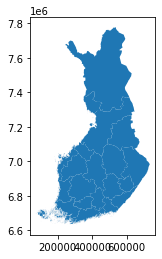

In [8]:
districts.plot()

## Join covid-19 cases to districts

join confirmed cases to districts based on common key:

In [9]:
covid_and_regions = districts.merge(covid, on="healthCareDistrict", how="left")

In [10]:
covid_and_regions.columns.values

array(['healthCareDistrict', 'geometry', 'id', 'date',
       'infectionSourceCountry', 'infectionSource'], dtype=object)

### Confirmed cases per region

In [11]:
id_count = covid_and_regions.groupby(by='healthCareDistrict').id.count()

In [12]:
id_count.rename("confirmed_count", inplace=True).sort_values(ascending=False)

healthCareDistrict
HUS                  18
Pirkanmaa             5
Varsinais-Suomi       1
Pohjois-Savo          1
Pohjois-Pohjanmaa     1
Lappi                 1
Kanta-Häme            0
Etelä-Karjala         0
Etelä-Pohjanmaa       0
Etelä-Savo            0
Itä-Savo              0
Kainuu                0
Kymenlaakso           0
Keski-Pohjanmaa       0
Keski-Suomi           0
Vaasa                 0
Länsi-Pohja           0
Pohjois-Karjala       0
Päijät-Häme           0
Satakunta             0
Ahvenanmaa            0
Name: confirmed_count, dtype: int64

Join count of cases to district polygons

In [13]:
districts = districts.merge(id_count, left_on='healthCareDistrict', right_index=True)

In [14]:
# Set zero to no data for plotting
districts.replace({0:np.nan}, inplace=True)

**NOTE:** it is generally not a good idea to show absolute values on a map. This plot is just for exploratory purposes..

(40857.339215, 765862.479085, 6575077.820610001, 7833703.7515899995)

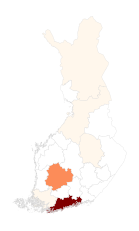

In [15]:
# Plot values on the map
districts.plot(column='confirmed_count', 
               cmap='OrRd', 
               edgecolor="lightgray", 
               linewidth=.2,
               scheme="Natural_Breaks", 
               k=3, 
               missing_kwds={'color': 'white'})

# Remove frame
plt.axis('off')

### Cases per source

In [16]:
source_count = covid_and_regions.groupby(by='infectionSourceCountry').id.count()

In [17]:
source_count.rename("cases_per_country", inplace=True)

infectionSourceCountry
CHN     1
FIN     8
ITA    18
Name: cases_per_country, dtype: int64

## Join sources to countries

In [18]:
# Geopandas comes with natural earth polygons
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [19]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [20]:
world = world.merge(source_count, left_on="iso_a3", right_index=True, how="left")

In [21]:
world[["name","cases_per_country"]].dropna()

,name,cases_per_country
139,China,1.0
141,Italy,18.0
151,Finland,8.0


... I stop here, but feel free to use these code snippets for further purposes! 

**REMINDER:** Data used in this repository is outdated.